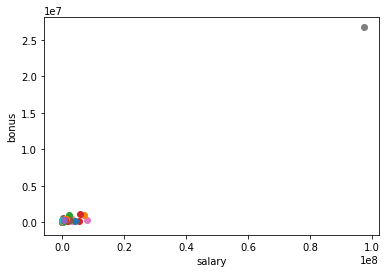

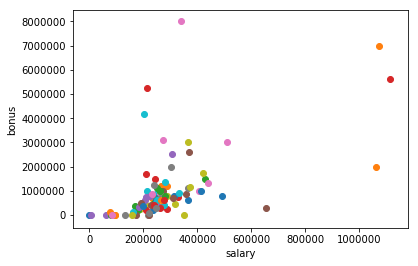

Decision Tree accuracy:  0.85
Decision tree algorithm time: 0.016 s
Naive Bayes accuracy: 0.85
Naive Bayes algorithm time: 0.0 s
done in 0.000s
Validating algorithm:
accuracy after tuning =  0.85
precision = 0.930
recall =  0.85


In [27]:
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
from tester import dump_classifier_and_data
sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi", "bonus_per_salary", "options_per_stock", 'bonus']

### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

#print data_dict.values()


### Task 2: Remove outliers

#Plot showing outlier
features=['bonus', 'salary']
data = featureFormat(data_dict, features)
for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary,bonus)
plt.xlabel('salary')
plt.ylabel('bonus')
plt.show()

### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### uncomment for printing top 4 salaries
### print outliers_final


#plot after removing the outlier
for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary,bonus)
plt.xlabel('salary')
plt.ylabel('bonus')
plt.show()



### Task 3: Create new feature(s)

### create new features
### bonus_per_salary, options_per_stock

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### creating new list of features
bonus_per_salary=dict_to_list("bonus","salary")
options_per_stock=dict_to_list("exercised_stock_options","total_stock_value")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["bonus_per_salary"]=bonus_per_salary[count]
    data_dict[i]["options_per_stock"]=options_per_stock[count]
    count +=1


### Store to my_dataset for easy export below.
my_dataset = data_dict


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)



### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred, labels_test)
print 'Decision Tree accuracy: ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]


### Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print "Naive Bayes accuracy:", accuracy

print "Naive Bayes algorithm time:", round(time()-t0, 10), "s"

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(pred, labels_test)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)
print 'precision = %0.3f' % precision_score(pred, labels_test, average='weighted')

# function for calculation ratio of true positives
# out of true positives and false negatives
print 'recall = ', recall_score(pred, labels_test, average= 'weighted')



### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)


In [14]:
print 'recall = ', recall_score(pred, labels_test, average = 'weighted')

recall =  0.85
